In [1]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import glob
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
import json

### Load the pretrained Dlib model for face landmarks

In [2]:
# Directory of the pretrained model
p = "shape_predictor_68_face_landmarks.dat"

# Pretrained dlib model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# Change hardcoded size
size = (480, 640, 3)

### Define the 3D points in World Coordinates. These will be the same for all images

In [3]:
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])

### Approximate Camera Intrinsic Parameters

In [4]:
# Approximate camera intrinsic parameters
focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion

### Load the dataset

In [ ]:
files_positive = glob.glob('test_dataset/positive/*.jpg')
files_negative = glob.glob('test_dataset/negative/*.jpg')

X = np.zeros((52, 6, 1))

for i in range(len(files_positive) + len(files_negative)):
    if i<len(files_positive):
        image = cv2.imread(files_positive[i])
    else:
        image = cv2.imread(files_negative[i-26])
    
    # Get faces into webcam's image
    rects = detector(image, 0)

    # Loop over every face detected. Here we only have on face each time
    for rect in rects:
        # Make the prediction and transfom it to numpy array
        shape = predictor(image, rect)
        landmarks = face_utils.shape_to_np(shape)
        
    # Grab the 2D coordinates of our six sample points
    image_points = np.array([
        landmarks[33, :],     # Nose tip
        landmarks[8, :],     # Chin
        landmarks[36, :],     # Left eye left corner
        landmarks[45, :],     # Right eye right corner
        landmarks[48, :],     # Left Mouth corner
        landmarks[54, :]      # Right mouth corner
    ], dtype="double")

    # Solve the PnP problem with the parameters specified above
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
        )
#     print("Rotation Vector:\n {0}".format(rotation_vector))
#     print("Translation Vector:\n {0}".format(translation_vector))
    
    X[i, :] = np.concatenate((rotation_vector, translation_vector), axis=0)

##### Load with json format

In [5]:
with open('data.json') as json_file:
    data = json.load(json_file)
with open('data_sorted.json') as json_file:
    keys = json.load(json_file)

print(data[keys[0]]['landmarks'][33])

{'x': 452, 'index': 33, 'y': 329}


In [8]:
X = np.zeros((42, 6, 1))
y = np.zeros(42)

for i in range(len(keys)):
    key = keys[i]
    im = cv2.imread('dataset/' + key)
    # Check if it is positive or negative example
    output = key.split('/')[1]
    
    if(output == 'positive'):
        y[i] = 1
    elif(output == 'negative'):
        y[i] = 0
    
    landmarks = data[key]['landmarks']
    
    # Grab the 2D coordinates of our six sample points
    image_points = np.array([
        (landmarks[33]['x'], landmarks[33]['y']) ,     # Nose tip
        (landmarks[8]['x'], landmarks[8]['y']),     # Chin
        (landmarks[36]['x'], landmarks[36]['y']),     # Left eye left corner
        (landmarks[45]['x'], landmarks[45]['y']),     # Right eye right corner
        (landmarks[48]['x'], landmarks[48]['y']),     # Left Mouth corner
        (landmarks[54]['x'], landmarks[54]['y'])      # Right mouth corner
    ], dtype="double")
    
    # Solve the PnP problem with the parameters specified above
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
        )
    # print("Rotation Vector:\n {0}".format(rotation_vector))
    # print("Translation Vector:\n {0}".format(translation_vector))
    
    X[i, :] = np.concatenate((rotation_vector, translation_vector), axis=0)


### Save and load data to save time/power

In [33]:
np.savetxt('input.out', X.squeeze(), delimiter=',')   # X is an array

In [2]:
X = np.loadtxt('input.out', delimiter=',')
print(X.shape)

(52, 6)


In [14]:
X = X.squeeze()
print(X.shape)

(42, 6)


In [15]:
# y = np.concatenate((np.zeros((26)), np.ones((26))), axis=0)
print(y.shape)

(42,)


In [45]:
np.savetxt('output.out', y, delimiter=',')   # X is an array

In [3]:
y = np.loadtxt('output.out', delimiter=',')
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


### Shuffle and split dataset

In [16]:
indexes = [i for i in range(42)]
shuffle(indexes)

X = X[indexes, :]
y = y[indexes, ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [17]:
print(y_test)

[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]


In [18]:
classifier = svm.SVC(kernel='linear')

In [19]:
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
y_pred = classifier.predict(X_test)

In [21]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.6923076923076923


# Visualizing training dataset

In [34]:
X = np.loadtxt('input.out', delimiter=',')
X[37, :3] = [-3, 0.5, 0.5]
print(X[37, :])

[-3.00000000e+00  5.00000000e-01  5.00000000e-01  2.88157491e+02
 -9.76285501e+00 -2.43266573e+03]


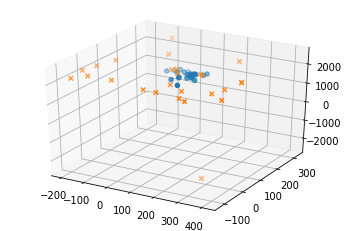

In [44]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot rotation vectors
# ax.scatter3D(X[0:26, 0], X[0:26, 1], X[0:26, 2], marker='o')
# ax.scatter3D(X[26:, 0], X[26:, 1], X[26:, 2], marker='x')

# Plot translation vectors
ax.scatter3D(X[0:26, 3], X[0:26, 4], X[0:26, 5], marker='o')
ax.scatter3D(X[26:, 3], X[26:, 4], X[26:, 5], marker='x')